In [ ]:
#################################################################################
# Project fMRI - Resting state study
#
# Aliénor Clerfayt, Suhrit Duttagupta, Jean-Charles Nicolas and Emilie Pons
#################################################################################

# Setup
We import libraries and the results of the 10 ICA component analysis from the database to apply on the rsMRI volumes. 


In [ ]:
###############################
# Installing required libraries
###############################
%matplotlib inline
!pip install boto3
import os
import boto3
from botocore.handlers import disable_signing
import re 
import numpy as np
client = boto3.client('s3')
client.meta.events.register('choose-signer.s3.*', disable_signing)
!pip install nilearn
from nilearn import plotting
from nilearn import image,masking
from scipy.fft import fft,fftfreq
from scipy.fftpack import fftshift
from scipy.signal import spectrogram
from matplotlib import pyplot as plt

##################################################################
# Import results from the 10 -Independent Component Analysis (ICA) 
# of Amsterdam Open MRI Collection to use in our study
# Details Published in Nature in 2021
##################################################################
import requests
URL="https://neurovault.org/media/images/7104/comp-"
if not os.path.exists('0tstat.nii.gz'):
  for i in range(10):
    response = requests.get(URL+str(i)+'_desc-dualreg_tstat.nii.gz')
    open(str(i)+'tstat.nii.gz', "wb").write(response.content)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 9.7 MB/s 
     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 9.9 MB 44.6 MB/s 
     |████████████████████████████████| 140 kB 6.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.4 MB/s 
     |████████████████████████████████| 127 kB 57.9 MB/s 
  Attem

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
###############################################################
# Importing Fourier transform functions and ploting functions
###############################################################
from scipy.fft import fft,fftfreq
from scipy.fftpack import fftshift
from scipy.signal import spectrogram
from matplotlib import pyplot as plt




# Functions for Masking
We define functions to build binary masks from coordinates of the ICA component maps. 

In [ ]:
import heapq
import nibabel as nb
import nilearn.masking as masking

###################################
# Define functions to create masks
###################################
def get_mm_coord(img,coords):
    x,y,z = coords
    shape, affine = img.shape[:3], img.affine
    coords = np.array(np.meshgrid(*(range(i) for i in shape),
                                  indexing='ij'))
    coords = np.rollaxis(coords, 0, len(shape) + 1)
    mm_coords = nb.affines.apply_affine(affine, coords)
    return np.round(mm_coords[x,y,z]).astype(int)

def get_volIdx(img,mm_coords):
    x,y,z = mm_coords
    inv_aff = np.linalg.inv(img.affine)
    idx_real = nb.affines.apply_affine(inv_aff,np.transpose(np.array([x,y,z])))
    return np.floor(idx_real).astype(int)

def build_mask_from_coord(img_,coords):
    x,y,z = coords
    img_segbool = np.zeros(np.array(img_.shape))
    img_segbool[x,y,z]=1
    return nb.Nifti1Image(img_segbool,  affine=img_.affine)
    


# **Functions for Signal**
The time-series from the masked MRI data will undergo drift removal and bandpass filtering. We will then take the Fourier Transformation to obtain the high and low frequencies from the signal. 


In [ ]:
import scipy, scipy.signal
from scipy.signal import butter, filtfilt
##############################################
# Define a butter filter for high or low band
##############################################

def butter_lowpass(cutoff, fs, order = 5):
    fnyq = 0.5 * fs
    normal_cutoff = cutoff / fnyq
    b, a = butter(order, normal_cutoff, btype = 'low', output = 'ba', fs = 2, analog = False)
    return b, a
def butter_highpass(cutoff, fs, order = 5):
    fnyq = 0.5 * fs
    normal_cutoff = cutoff / fnyq
    b, a = butter(order, normal_cutoff, btype='high', output = 'ba', fs = 2, analog = False)
    return b, a
def butter_filter(data, cutoff, fs, order=5, filtype=''):
    if filtype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, fs, order=order)
    elif filtype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, fs, order=order)        
        
    y = filtfilt(b, a, data)
    return y

def filt(ts):
  dt = 2 # Use Time of repetition (TR) of the Echo planar image (EPI) acquisition
  fs = 1/dt # Sampling Frequency
  time_vec= np.array(range(0,len(ts)*dt,dt))
  #Removing drift using curve fitting
  def test_func(x,a0,a,b,c,d):
        return a0+a*x+b*x**2+c*x**3+d*x**4
 
 
  params,params_cov = scipy.optimize.curve_fit(test_func,time_vec,ts)
  a0,a,b,c,d = params[0],params[1],params[2],params[3],params[4]
  drift = [test_func(x,a0,a,b,c,d) for x in time_vec] # Calculate the drift
  yf = ts-drift  # We remove the drift

#####################
# High pass Filtering
#####################
  order = 6
  fc = 0.01  # desired cutoff frequency of the filter, Hz
  fs = 1/dt
  # Get the filter coefficients so we can check its frequency response.
  b,a = butter_highpass(fc, fs, order) #Numerator (b) and denominator (a) polynomials of the IIR filter. 
  y_filt = butter_filter(yf, fc, fs, order, 'highpass')

#####################
# Low pass Filtering
#####################
  fc = 0.15 
  order = 5
  fs = 1/dt
  # Get the filter coefficients so we can check its frequency response.
  b,a = butter_lowpass(fc, fs, order) #Numerator (b) and denominator (a) polynomials of the IIR filter.
  y_tfilt = butter_filter(y_filt, fc, fs, order, 'lowpass')
  return y_tfilt

############################
# Fast Fourier Transform
############################

def FFT(signal,freq):
  #FFT of the filtered signal and returning the required frequencies
  dt = 2
  N = 3*len(signal)//10 # number of FFT points (length of signal)
  Y = fft(signal/signal.mean(),N) # calculate the FFT
  tyF = fftfreq(N, dt)[:N//2]
  if freq =='low':
    return abs(Y[0:N//4])
  elif freq =='high':
    return abs(Y[N//4:N//2])
  elif freq =='all':
    return abs(Y[:N//2])
########################################
# Define correlation between two signals
########################################
def corr(Y1,Y2):
  correlate = scipy.stats.pearsonr(Y1,Y2)
  return correlate[0]


# Analysis
Using the top 100 values from the ICA components, we apply the binary masks on the volumes and correlate the high frequency and low frequency signals from the Fourier transformed voxel time-series. 

In [ ]:
##########################################################
# This code is built to be versatile and allow to select 
# between all frequencies or only low and high ones
##########################################################
####################################################################
# We are selecting only the first 2 subjects from the PIOP2 database
# as a proof of concept for our study
# But there are 226 subjects in the datasets available on openneuro.org PIOP2
####################################################################

# MULTI-SUBJECT ANALYSIS
import os.path

#allmat=[]
highmat=[]
lowmat=[]
#Loop for choosing number of subjects
subj=[i for i in range(1,3)] #Select number of subjects up to 226, here the first 2 only
for i in subj: 
  key="sub-"+str(i).zfill(4)
# Download_file from openneuro.org
  file_key = "ds002790/derivatives/fmriprep/"+key+"/func/"+key+"_task-restingstate_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
  client.download_file('openneuro.org', file_key, str(i)+'-resting.nii.gz')
  img = image.load_img(str(i)+'-resting.nii.gz')
  #Lists for collecting ICA results
  #allfreq=[]  We are not taking correlation of all different frequencies to save computing time 
  lowfreq=[]
  highfreq=[]

#############################################
#Loop for applying ICA masks and correlation
#############################################
  icacomp=[1,8] #Picking only the 1 and 8 ICA masks
  for icaf in icacomp: 
    icafile=str(icaf)+"tstat.nii.gz"
    img_ica=image.load_img(icafile)
    thr=min(heapq.nlargest(100,img_ica.get_fdata().flatten())) #Threshold for getting binary mask from top 100 voxels
    #Creating masks
    xz,yz,zz=(np.where((img_ica.get_fdata())>=thr))
    xm,ym,zm= np.transpose(get_mm_coord(img_ica,np.array([xz,yz,zz])))
    x,y,z=np.transpose(get_volIdx(img,[xm,ym,zm]))
    mean_img=image.mean_img(img)
    nii_mask=build_mask_from_coord(mean_img,[x,y,z])

###################################################################################    
# Calculation of correlation for general, high, or low frequencies from masked data
###################################################################################

    masked_data = masking.apply_mask(imgs=img, mask_img= nii_mask)
    length=masked_data.shape[1]
    #matrix1=np.zeros((length,length)) 
    matrix2=np.zeros((length,length))
    matrix3=np.zeros((length,length))
    for mat1 in range(length):
      for mat2 in range(length):
        #matrix1[mat1][mat2]=corr(FFT(filt(masked_data[:,mat1]),'all'),FFT(filt(masked_data[:,mat2]),'all'))  Not taking correlation of all frequencies to save computing time 
        matrix2[mat1][mat2]=corr(FFT(filt(masked_data[:,mat1]),'high'),FFT(filt(masked_data[:,mat2]),'high'))
        matrix3[mat1][mat2]=corr(FFT(filt(masked_data[:,mat1]),'low'),FFT(filt(masked_data[:,mat2]),'low'))
    #allfreq.append(matrix1)
    highfreq.append(matrix2)
    lowfreq.append(matrix3)
  #Appending to list for data from multiple subjects
  #allmat.append(np.array(allfreq)) #only for all
  highmat.append(np.array(highfreq))
  lowmat.append(np.array(lowfreq))
highmat=np.array(highmat)
lowmat=np.array(lowmat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
#Checking difference in correlations by t-test 
corrhigh=[]
corrlow=[]
corrt=0.6 #Threshold for correlation
for i in range(len(highmat)):
  for j in range(len(highfreq)):
    corrhigh.append(len(highmat[i][j][(highmat[i][j]>corrt)])/len(highmat[i][j].flatten()))
    corrlow.append(len(lowmat[i][j][(lowmat[i][j]>corrt)])/len(lowmat[i][j].flatten()))
print(scipy.stats.ttest_ind(corrhigh,corrlow))

Ttest_indResult(statistic=21.819771347008324, pvalue=6.052338261528279e-07)


# Plotting
We plot the clustering of correlation matrices.

Subject 1 - ICA component 1

Text(0.5, 0.98, 'Correlation Matrix of Low Frequencies (Subject 1, ICA 1)')

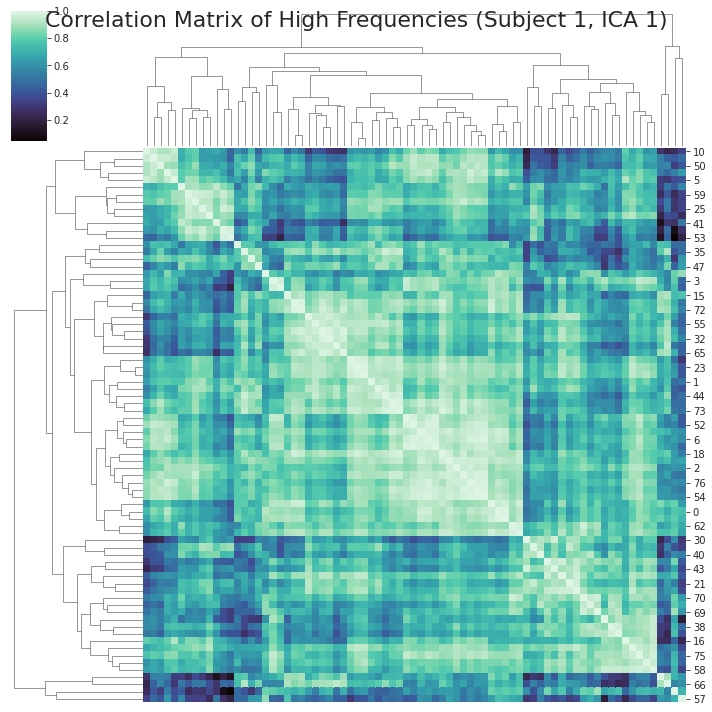

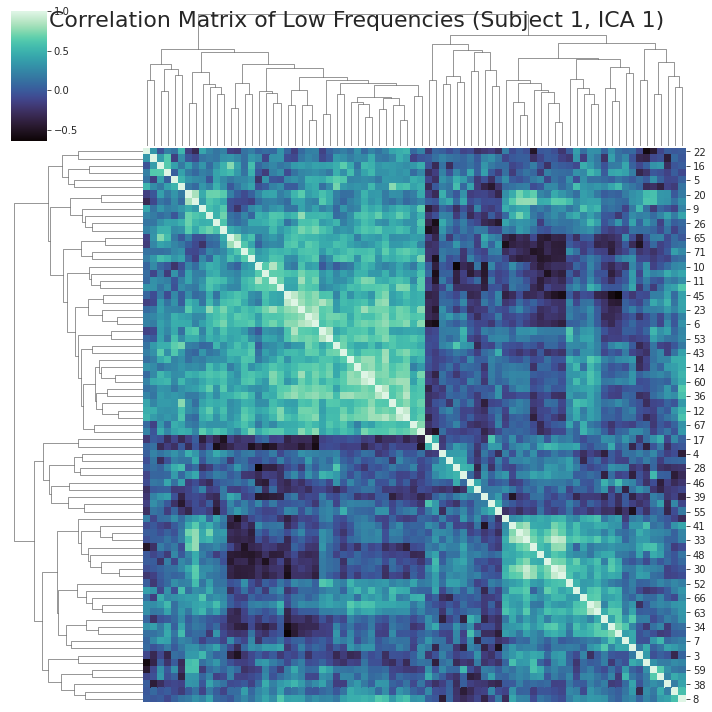

In [ ]:
###############################################
# Produce results using clustering graphics
###############################################

import seaborn as sns, numpy as np, matplotlib.pyplot as plt
############################
# 1 - Subject One Mask One
############################
sns.set_style("whitegrid")
g=sns.clustermap(highmat[0][0],cmap='mako',xticklabels=False) 
g.fig.suptitle('Correlation Matrix of High Frequencies (Subject 1, ICA 1)', size=22)
h=sns.clustermap(lowmat[0][0],cmap='mako',xticklabels=False)
h.fig.suptitle('Correlation Matrix of Low Frequencies (Subject 1, ICA 1)', size=22)



Eighth ICA component

Text(0.5, 0.98, 'Correlation Matrix of Low Frequencies (Subject 1, ICA 8)')

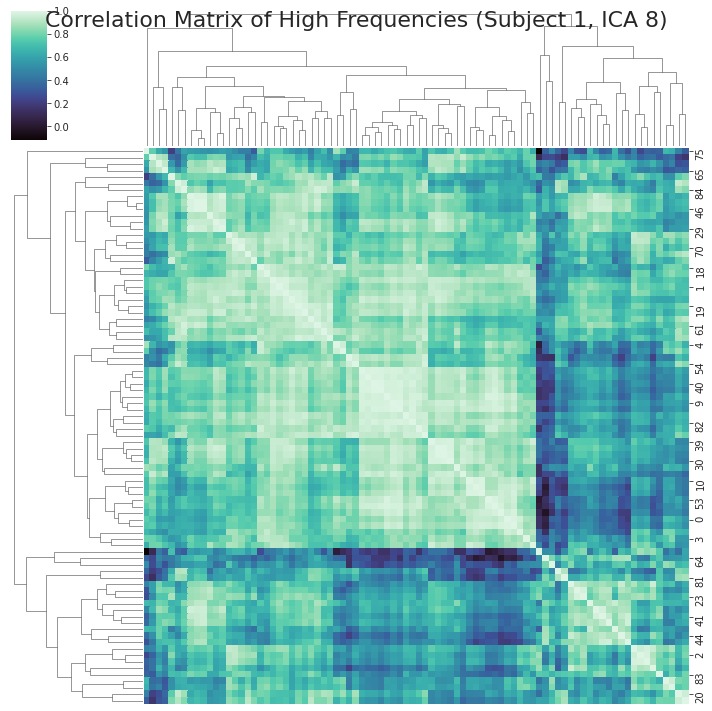

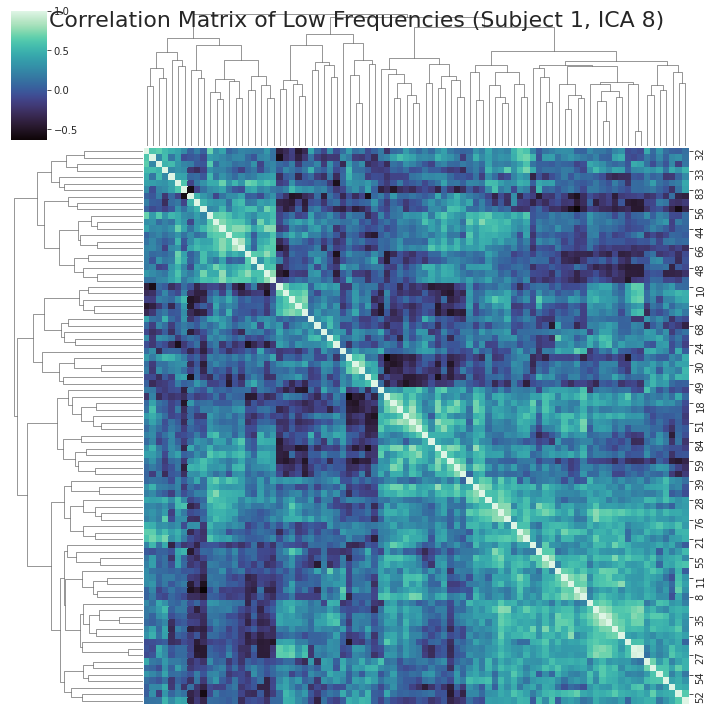

In [ ]:
import seaborn as sns, numpy as np, matplotlib.pyplot as plt

############################
# 2- Subject One Mask Eight
############################
sns.set_style("whitegrid")
g=sns.clustermap(highmat[0][1],cmap='mako',xticklabels=False) 
g.fig.suptitle('Correlation Matrix of High Frequencies (Subject 1, ICA 8)', size=22)
h=sns.clustermap(lowmat[0][1],cmap='mako',xticklabels=False)
h.fig.suptitle('Correlation Matrix of Low Frequencies (Subject 1, ICA 8)', size=22)

**Subject 2**

Text(0.5, 0.98, 'Correlation Matrix of Low Frequencies (Subject 2, ICA 1)')

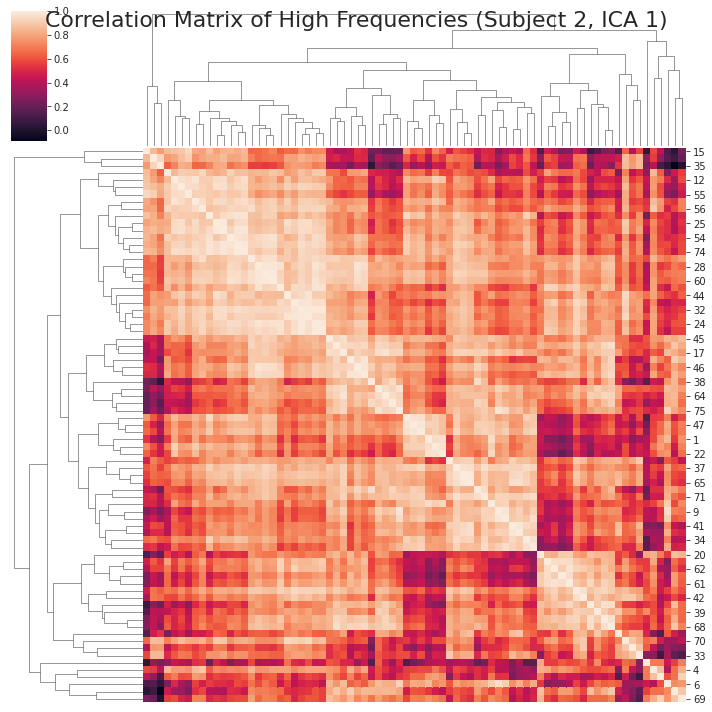

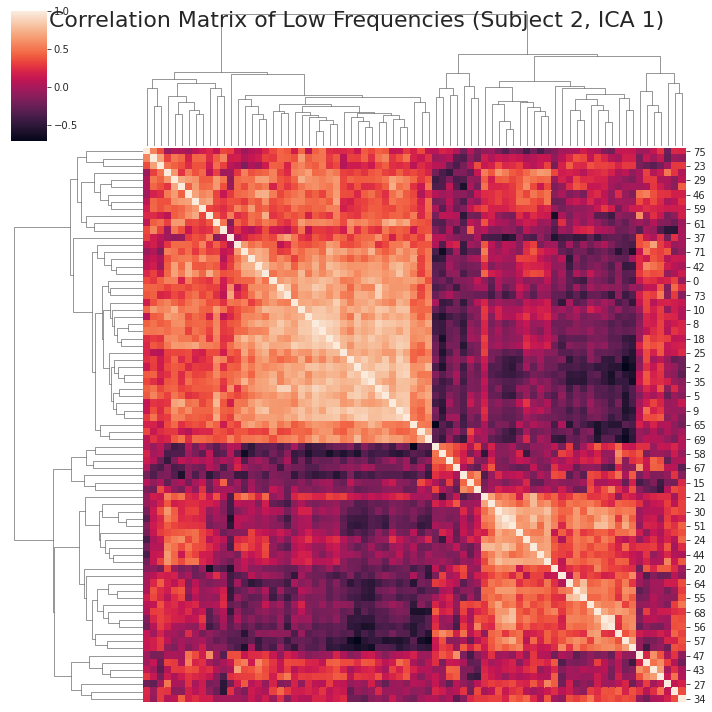

In [ ]:
############################
# 3 - Subject Two Mask One
############################


sns.set_style("whitegrid")
g=sns.clustermap(highmat[1][0],xticklabels=False) 
g.fig.suptitle('Correlation Matrix of High Frequencies (Subject 2, ICA 1)', size=22)
h=sns.clustermap(lowmat[1][0],xticklabels=False)
h.fig.suptitle('Correlation Matrix of Low Frequencies (Subject 2, ICA 1)', size=22)

Eighth ICA component

Text(0.5, 0.98, 'Correlation Matrix of Low Frequencies (Subject 2, ICA 8)')

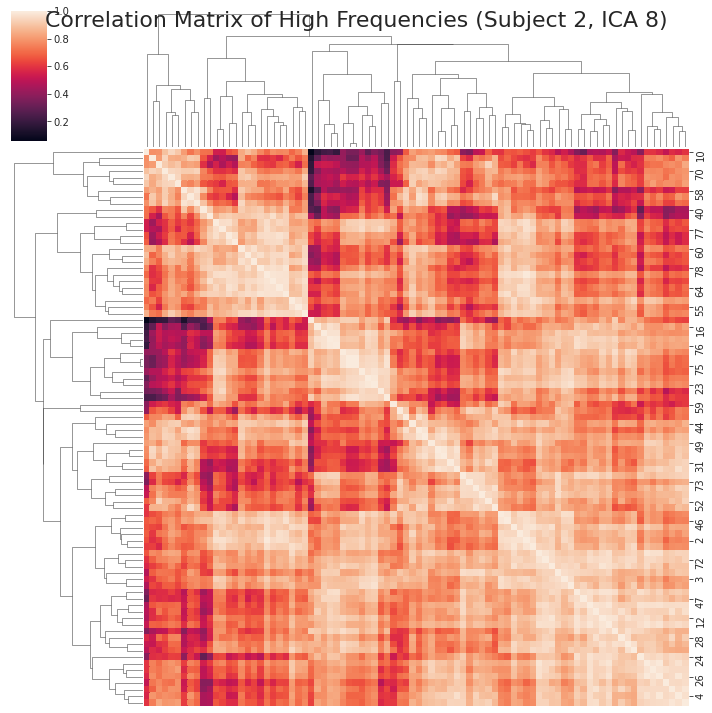

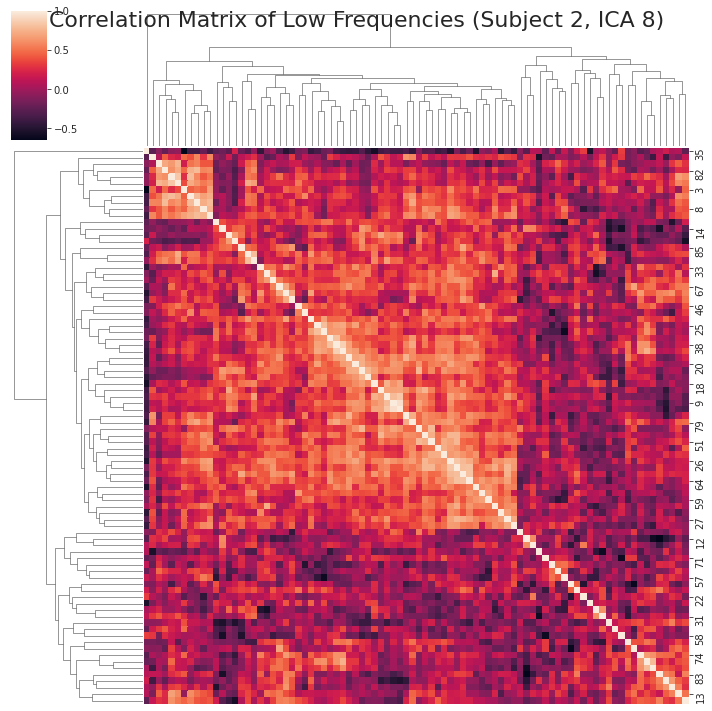

In [ ]:
############################
# 3 - Subject Two Mask Eight
############################


sns.set_style("whitegrid")
g=sns.clustermap(highmat[1][1],xticklabels=False) 
g.fig.suptitle('Correlation Matrix of High Frequencies (Subject 2, ICA 8)', size=22)
h=sns.clustermap(lowmat[1][1],xticklabels=False)
h.fig.suptitle('Correlation Matrix of Low Frequencies (Subject 2, ICA 8)', size=22)

# Supplementary
Additional code to illustrate the entire process for extracting the FFT of a voxel from the first subject.

In [ ]:
##############################################################
# Loading Resting State images from AOMIC PIOP2 for subject 0001
##############################################################

#  Filter the data to include resting state only

paginator = client.get_paginator('list_objects')

operation_parameters = {'Bucket': 'openneuro.org',
                        'Prefix': 'ds002790/derivatives/fmriprep/sub-0001/func'}

result = paginator.paginate(**operation_parameters)
filtered_iterator = result.search("Contents[?Key.contains(@,'task-restingstate')]")
task_list=[key_data['Key'] for key_data in filtered_iterator]
# 2 - Use Panda library to select our files

import pandas as pd

# Use Panda library to split files
files= np.array(task_list) #transform task list in np array np.array(task_list)
# Generate a list using split
filename_split = []
for i in files:
    filename_split.append(i[44:].split('_'))

# make a panda Data Frame with filename  pd.DataFrame( filename_split)[5]
pd_filename_list= pd.DataFrame(filename_split) 
# Run through all files with nii.gz endings
nii_task=np.array([x.endswith('nii.gz') for x in task_list]) 
nii_files=np.asarray(task_list)[nii_task]
pd.DataFrame([y.split("_") for y in pd.DataFrame([x.split("/") for x in  nii_files])[5] ])

#######################################
# Loading first ICA image
#######################################



response = requests.get('https://neurovault.org/media/images/7104/comp-1_desc-dualreg_tstat.nii.gz')
open('1tstat.nii.gz', "wb").write(response.content)

icafile="0tstat.nii.gz"

In [ ]:

file_key=nii_files[4]

import os.path

# s3 client download_file
if not  os.path.exists( "resting.nii.gz"):
    client.download_file('openneuro.org', file_key, 'resting.nii.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


(65, 77, 60, 240)


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



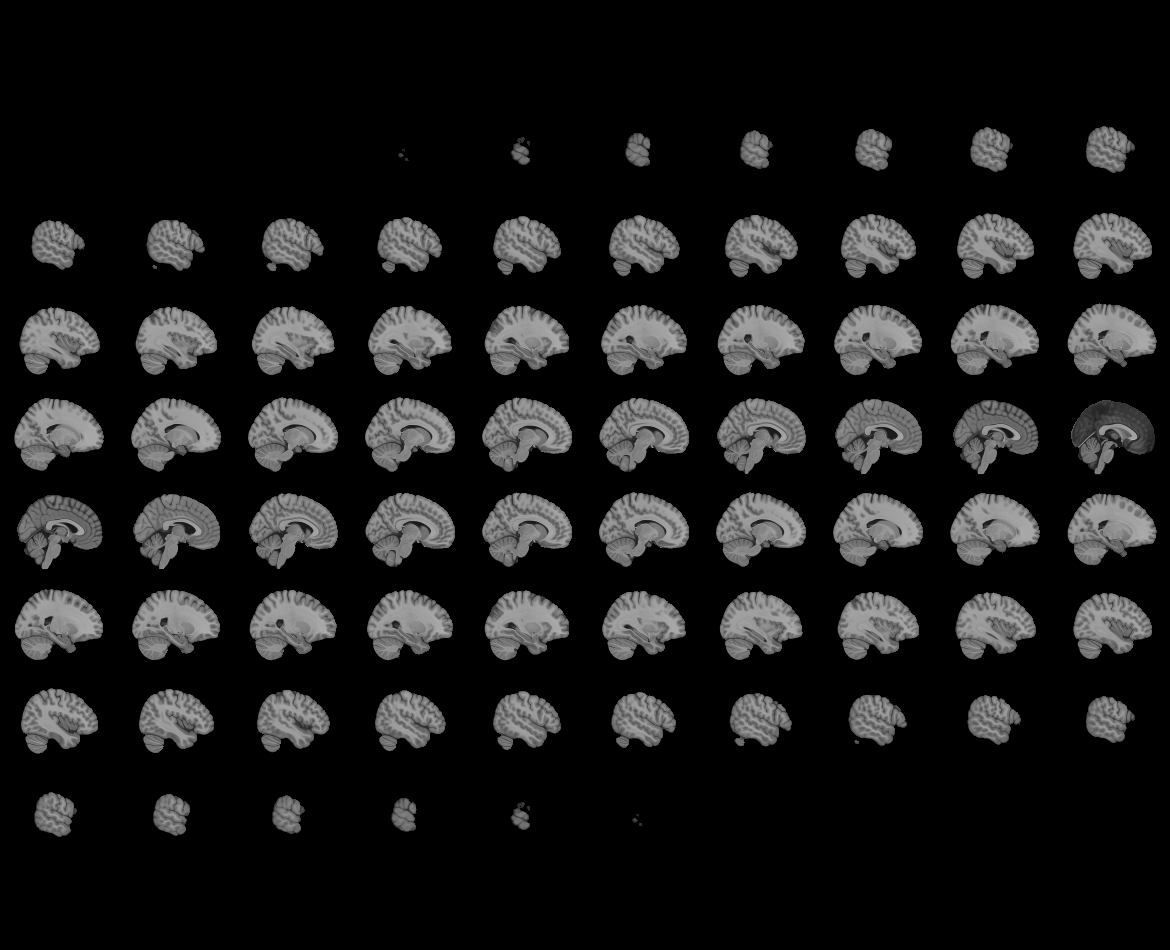
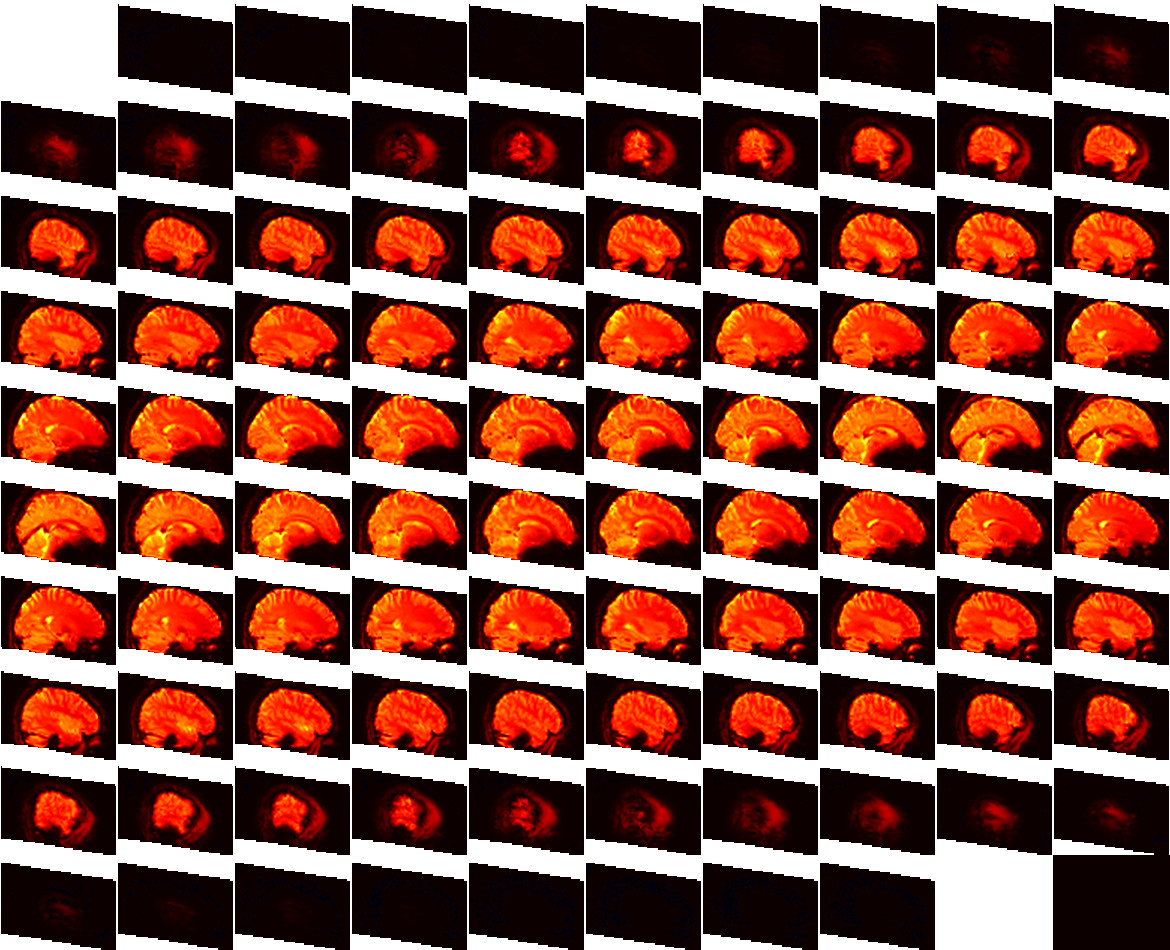

In [ ]:
img= image.load_img('resting.nii.gz')  # load your image with image.load_img
print(img.get_data().shape)
# launch interactive 3d view with view_img function
plotting.view_img(image.index_img(img, 0))

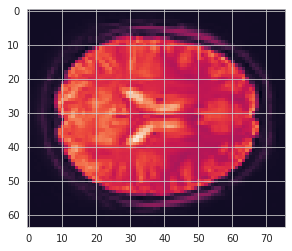

In [ ]:
from matplotlib import pyplot as plt
volume= img.get_fdata() # extract voil;ume data from image
flat_slice=volume[1:,1:,30,0]
plt.imshow(flat_slice, interpolation='nearest')
plt.show()

In [ ]:
icafile="0tstat.nii.gz"
img_ica=image.load_img(icafile)
print(img_ica.get_data().shape)

(65, 77, 60)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:

#x,y,z=(np.unravel_index(np.argmax(img_zscore.get_data()),img_zscore.get_data().shape))

# determine top 100 vx threshold :
thr=min(heapq.nlargest(100,img_ica.get_data().flatten()))
print(thr)
xz,yz,zz=(np.where((img_ica.get_data())>=thr))
#print(xz,yz,zz)
xm,ym,zm= np.transpose(get_mm_coord(img_ica,np.array([xz,yz,zz])))
#print(xm,ym,zm)
x,y,z=np.transpose(get_volIdx(img,[xm,ym,zm]))
#print(x,y,z)


mean_img=image.mean_img(img)
nii_mask=build_mask_from_coord(mean_img,[x,y,z])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


55.387787


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



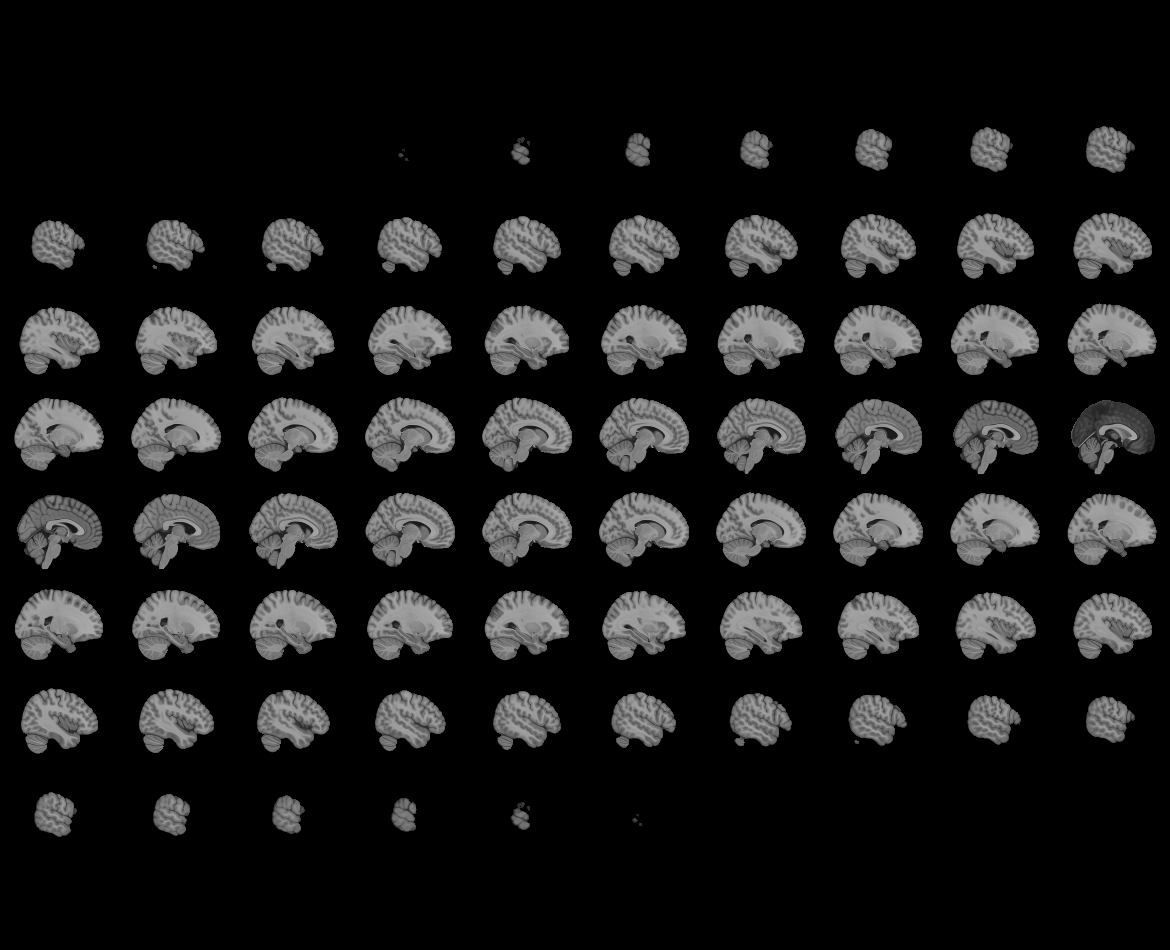
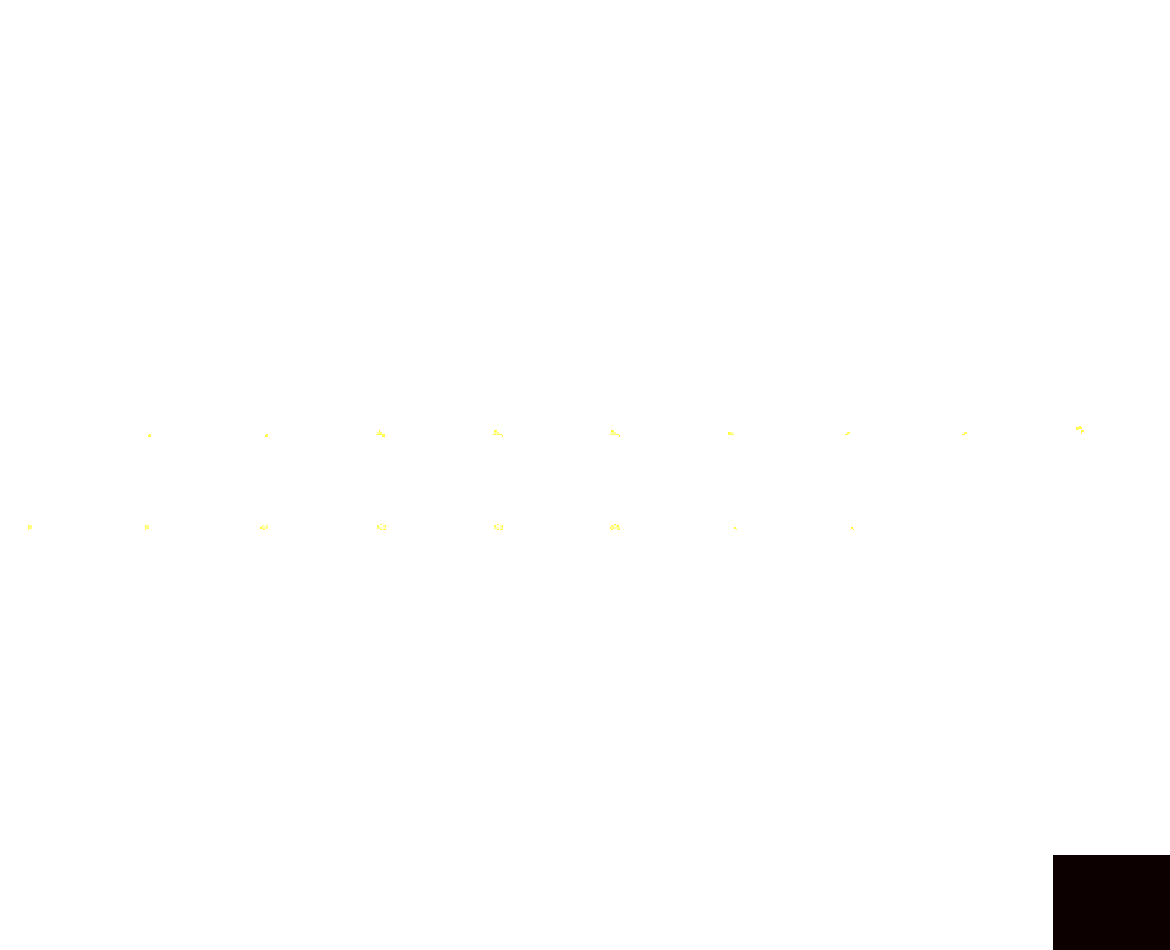

In [ ]:
plotting.view_img((img_ica),threshold=thr,resampling_interpolation="nearest")

In [ ]:
plotting.view_img(nii_mask,resampling_interpolation="nearest")
masked_data = masking.apply_mask(imgs=img, mask_img= nii_mask)
masked_data.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(240, 81)

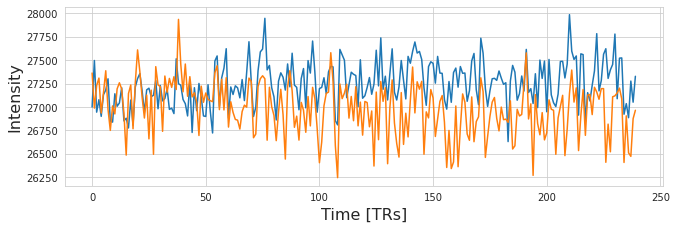

In [ ]:
# And now plot two time series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(masked_data[:, :2])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


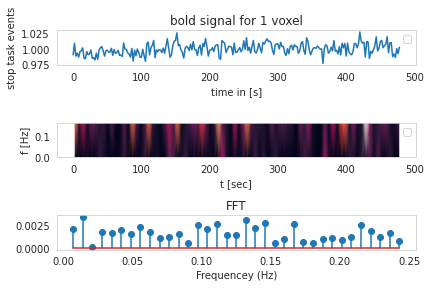

In [ ]:
from scipy.fft import fft,fftfreq
from scipy.fftpack import fftshift
from scipy.signal import spectrogram
from matplotlib import pyplot as plt

ts=masked_data[:,0] ## example with 1 vx

dt = 2#  use TR of the EPI acqisition
fs = 1/dt

# time vector
time_vec= np.array(range(0,len(ts)*dt,dt))

# Calculate the FFT
L =masked_data.shape[0]# find out the number of acquisitions 
ax1=plt.subplot(311)
plt.plot(time_vec, ts/ts.mean())#, label='bold signal at'+np.array2string([x,y,z]), linewidth=0.5)
plt.ylabel('bold signal')
plt.title('bold signal for 1 voxel')
# Add title and labels
plt.ylabel('stop task events')
plt.xlabel('time in [s]')
# Display plot
plt.grid()
# Add legend
plt.legend()

plt.subplot(312, sharex=ax1)
#plot windowed t/f analysis 
freqs, times, spectro = spectrogram( ts/ts.mean(),fs=fs, nperseg=3)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.ylabel('f [Hz]')
plt.xlabel('t [sec]')
#plt.yscale('symlog')
plt.legend()


plt.subplot(313)
N = 3*len(ts)//10 # number of FFT points (length of signal)
#N=len(time_vec)
Y2=fft(ts/ts.mean(),N)
fv=fftfreq(N,dt)[:N//2]
plt.stem(fv[1:N//2],2.0/N*np.abs(Y2[1:N//2]))
plt.title("FFT")
plt.xlabel("Frequencey (Hz)")
plt.grid()

# Auto space
plt.tight_layout()
plt.show()
